c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


6878 x 6878 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
6650 x 46550 km x 63.4 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)


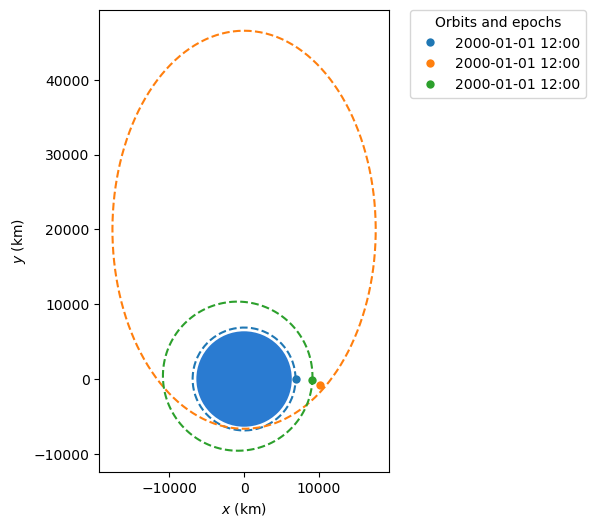

In [1]:
from astropy.time import Time

from matplotlib import pyplot as plt

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya

#Need lambert solver

epoch = Time("2018-08-17 12:05:50", scale="tdb")

# plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# print(StaticOrbitPlotter)
# plotter.plot_body_orbit(Earth, epoch, label="Earth")
# plotter.plot_body_orbit(Mars, epoch, label="Mars")
ss_leo = Orbit.circular(Earth,alt=500*u.km)

a = 10000<< u.km
ecc = 0.093315 << u.one
inc = 0 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

ss_elliptic = Orbit.from_classical(Earth,a,ecc,inc,raan,argp,nu)
ss_molniya = Orbit.from_classical(Earth,molniya.a,molniya.ecc,molniya.inc,molniya.raan,molniya.argp,molniya.nu)

print(ss_leo)
print(molniya)
plotter = StaticOrbitPlotter(plane = Planes.EARTH_EQUATOR)
plotter.set_attractor(Earth)
plotter.plot(ss_leo)
ss_molniya.inc=0 << u.deg
plotter.plot(ss_molniya)
plotter.plot(ss_elliptic)


# # # Plotting
# plotter = OrbitPlotter2D()
# # plotter.plot(ss_leo, label="LEO")
# # plotter.plot(molniya, label="Molniya")
# plt.show()



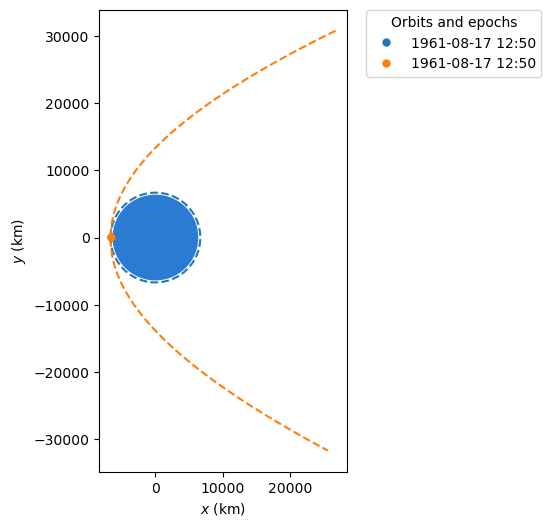

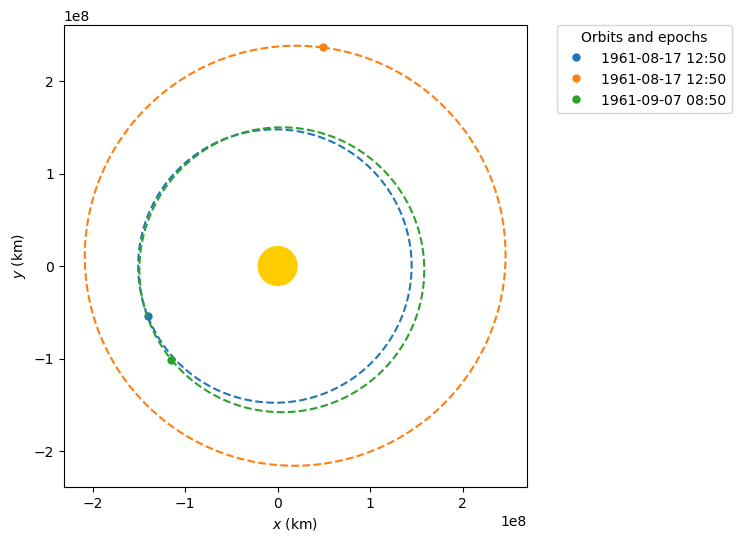

In [2]:
from astropy.time import Time
import numpy as np
from matplotlib import pyplot as plt

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

from ipywidgets import interact, FloatSlider



a = Earth.R + 300*u.km
ecc = 0 << u.one
inc = 0 << u.deg
raan = 0 << u.deg
argp = 0 << u.deg
nu = 0 << u.deg

epoch1 = Time("1961-08-17 12:05:50", scale="tdb")###Baseline zero epoch
epoch2 = Time("1961-08-17 12:50:50", scale="tdb")
epoch3 = Time("1964-08-17 12:05:50", scale="tdb")

tej = epoch2-epoch1

soiEscapeTime = 500

##setting up basic parems
earth_ephem = Ephem.from_body(Earth, time_range(epoch2, end=epoch3))
ss_earth = Orbit.from_ephem(Sun, earth_ephem, epoch2)
mars_ephem = Ephem.from_body(Mars, time_range(epoch2, end=epoch3))
ss_mars = Orbit.from_ephem(Sun, mars_ephem, epoch2)

# Create sliders
dv_slider = FloatSlider(min=0, max=10, step=0.1, value=5, description='Delta-V (km/s)')
ejection_angle_slider = FloatSlider(min=0, max=360, step=1, value=180, description='Ejection Angle (degrees)')

ss_initial = Orbit.from_classical(Earth,a,ecc,inc,raan,argp,nu,epoch=epoch1)
ss_initial = ss_initial.propagate(tej)
##Now perform a burn

def returnPrograde(incOrb):
    prograde_v = incOrb.v / np.sqrt(np.sum(incOrb.v**2)).value << u.km/u.s
    return prograde_v

#loop until the orbit is an escape orbit, calculating how much to escape earth
dv = 0
man = Maneuver((0 * u.s, dv*returnPrograde(ss_initial)))
ss_final = ss_initial.apply_maneuver(man)
while(ss_final.ecc < (1*u.one)):
    dv=dv+0.1
    man = Maneuver((0 * u.s, dv*returnPrograde(ss_initial)))
    ss_final = ss_initial.apply_maneuver(man)
escapedv = dv
##Propogate this escape orbit to see what the velocity is at edge of earth SOI, which is 10^6km frm earth
soi_escape_earth = ss_final.propagate(soiEscapeTime << u.hour)
##need to find pos,velocity relative to sun at soi_escape_orb
###vel should just be earthVel + spaceCraftVel
ss_earth_soi_cross = ss_earth.propagate(soiEscapeTime << u.hour)
pos_spacecraft = ss_earth_soi_cross.r+soi_escape_earth.r
vel_spacecraft = ss_earth_soi_cross.v+soi_escape_earth.v
spacecraftSolarOrb = Orbit.from_vectors(Sun,pos_spacecraft,vel_spacecraft,epoch2+soiEscapeTime*u.hour)



##########Prob SHIT below
# speed_initial = np.sqrt(pow(ss_initial.v[0],2)+pow(ss_initial.v[1],2)+pow(ss_initial.v[2],2))
# prograde_v = (ss_initial.v/speed_initial) 
# print(prograde_v[0])

plotter = StaticOrbitPlotter(plane = Planes.EARTH_EQUATOR)
plotter.set_attractor(Earth)
plotter.plot(ss_initial)
plotter.plot(ss_final)

secondplotter = StaticOrbitPlotter()
secondplotter.set_attractor(Sun)
secondplotter.plot(ss_earth)
secondplotter.plot(ss_mars)
secondplotter.plot(spacecraftSolarOrb)




In [3]:
from astropy.time import Time
import numpy as np
from matplotlib import pyplot as plt
from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range
from ipywidgets import interact, FloatSlider

epoch1 = Time("1961-08-17 12:05:50", scale="tdb")###Baseline zero epoch
epoch2 = Time("1962-10-17 12:50:50", scale="tdb")
epoch3 = Time("1964-08-17 12:05:50", scale="tdb")


soiEscapeTime = 500
##setting up basic parems
earth_ephem = Ephem.from_body(Earth, time_range(epoch2, end=epoch3))
ss_earth = Orbit.from_ephem(Sun, earth_ephem, epoch2)
mars_ephem = Ephem.from_body(Mars, time_range(epoch2, end=epoch3))
ss_mars = Orbit.from_ephem(Sun, mars_ephem, epoch2)


def returnPrograde(incOrb):
    prograde_v = incOrb.v / np.sqrt(np.sum(incOrb.v**2)).value << u.km/u.s
    return prograde_v


# Define your orbital transfer function
def plot_orbital_transfer(dv, ejection_angle):
    # Your poliastro calculations and plotting logic goes here 
    a = Earth.R + 300*u.km
    ecc = 0 << u.one
    inc = 0 << u.deg
    raan = 0 << u.deg
    argp = 0 << u.deg
    nu = 0 << u.deg
    print(type(ejection_angle))   
    ss_initial = Orbit.from_classical(Earth,a,ecc,inc,raan,argp,nu,epoch=epoch1)
    ss_initial = ss_initial.propagate_to_anomaly(ejection_angle*u.deg) 
    ##Apply burn
    man = Maneuver((0 * u.s, dv*returnPrograde(ss_initial)))
    ss_final = ss_initial.apply_maneuver(man)
    ##Propogate this escape orbit to see what the velocity is at edge of earth SOI, which is 10^6km frm earth
    soi_escape_earth = ss_final.propagate(soiEscapeTime << u.hour)
    
    ##need to find pos,velocity relative to sun at soi_escape_orb
    ###vel should just be earthVel + spaceCraftVel
    current_epoch = epoch2+soiEscapeTime*u.hour
    ss_earth_soi_cross = ss_earth.propagate(current_epoch)
    pos_spacecraft = ss_earth_soi_cross.r+soi_escape_earth.r
    vel_spacecraft = ss_earth_soi_cross.v+soi_escape_earth.v
    spacecraftSolarOrb = Orbit.from_vectors(Sun,pos_spacecraft,vel_spacecraft,current_epoch)

#####Next non implimented steps are to propogate orbit to node, perform plane change which should be noted in total cost
#####Then propogate orbit to Mars approach, simulate said approach to Mars, perhaps simulate aerobraking, plot ground
#####track arrival to mars

    ##Perform plane change to remove out of plane seperation

    
    ##Now find approach to mars, propogate orbit till it begins to approach mars
    mars_orb = Orbit.from_ephem(Sun, mars_ephem, current_epoch)
    min_dist = np.linalg.norm(spacecraftSolarOrb.r-mars_orb.r)
    propTime = 6<<u.hour
    totalTime = 0 * u.hour
    #should fine closest approach to amrs
    while np.linalg.norm(spacecraftSolarOrb.r-mars_orb.r)<= min_dist:
        min_dist = np.linalg.norm(spacecraftSolarOrb.r-mars_orb.r)
        mars_orb = mars_orb.propagate(propTime)
        spacecraftSolarOrb = spacecraftSolarOrb.propagate(propTime)     
        totalTime += propTime
        current_epoch += propTime
        if totalTime > 1*u.year:
            break
            
    print(min_dist)   
    print(current_epoch)
    ###Plot admin
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ###Plot w reference earth
    earth_plot = StaticOrbitPlotter(ax1)
    earth_plot.set_attractor(Earth)
    earth_plot.plot(ss_initial)   
    earth_plot.plot(ss_final)

    ###Plot w reference sun
    sun_plot = StaticOrbitPlotter(ax2)
    sun_plot.set_attractor(Sun)
    sun_plot.plot(ss_earth)
    sun_plot.plot(mars_orb)
    sun_plot.plot(spacecraftSolarOrb)
    pass

# Create sliders
dv_slider = FloatSlider(min=0, max=10, step=0.03, value=5, description='Delta-V (km/s)')
ejection_angle_slider = FloatSlider(min=0, max=360, step=1, value=180, description='Ejection Angle (degrees)')

# Link sliders to the function
interact(plot_orbital_transfer, dv=dv_slider, ejection_angle=ejection_angle_slider)


interactive(children=(FloatSlider(value=5.0, description='Delta-V (km/s)', max=10.0, step=0.03), FloatSlider(v…

<function __main__.plot_orbital_transfer(dv, ejection_angle)>

[-0.01509845  0.00466315  0.00200411] AU
4806 x -7627 km x 45.1 deg (MarsICRS) orbit around Mars (♂) at epoch 1963-05-16 12:50:50.000 (TDB)


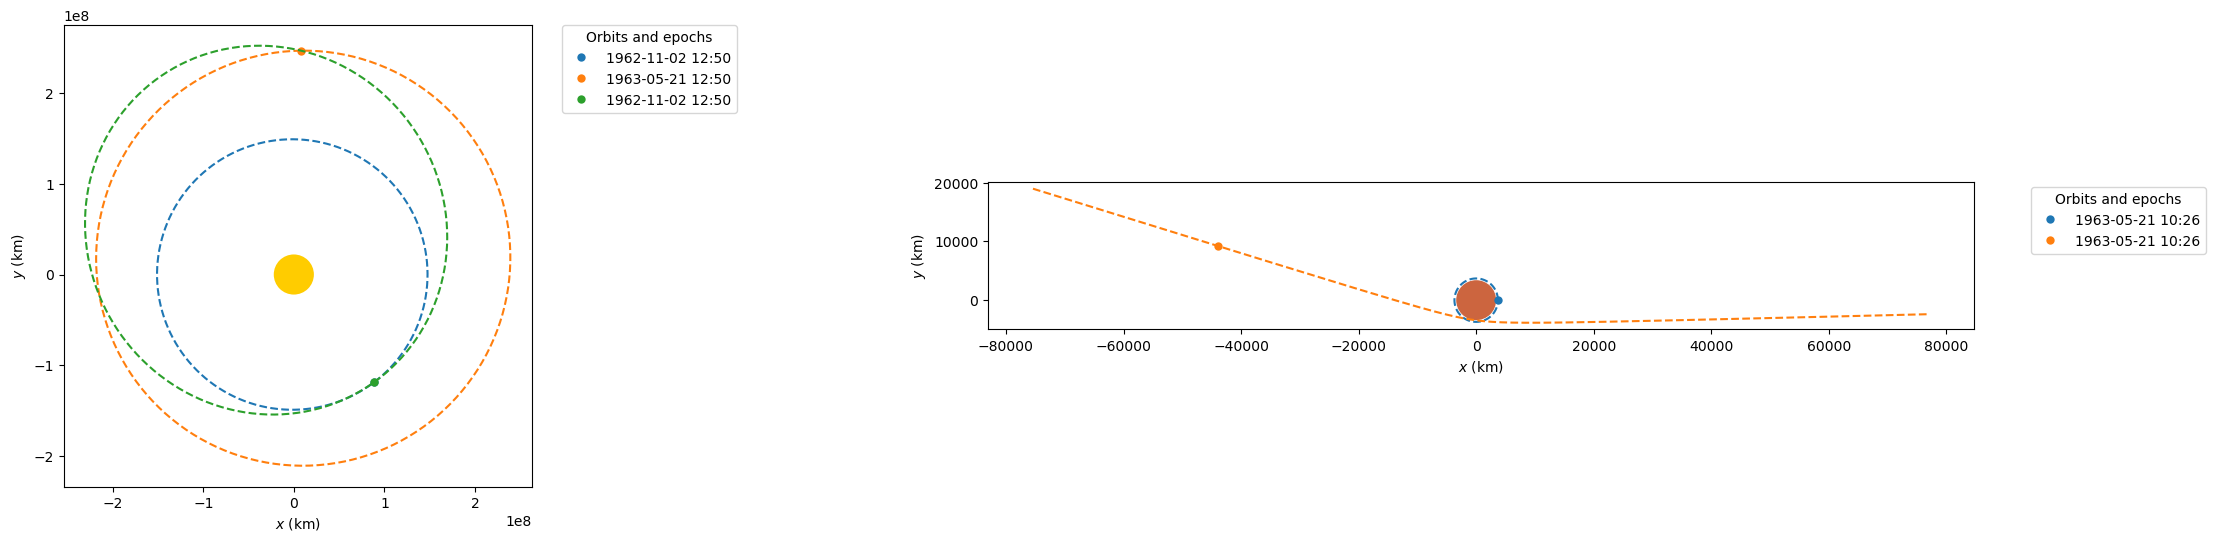

In [4]:
from astropy.time import Time
import numpy as np
from matplotlib import pyplot as plt
from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range
from ipywidgets import interact, FloatSlider

epoch1 = Time("1961-08-17 12:05:50", scale="tdb")###Baseline zero epoch
epoch2 = Time("1962-10-17 12:50:50", scale="tdb")
epoch3 = Time("1964-08-17 12:05:50", scale="tdb")


soiEscapeTime = 500
##setting up basic parems
earth_ephem = Ephem.from_body(Earth, time_range(epoch2, end=epoch3))
mars_ephem = Ephem.from_body(Mars, time_range(epoch2, end=epoch3))

###Find low DV arrival
minDv = 10000##arbitarely high
finalDeparture = False
finalArrival = False
for i in range(365):
    departureTime = epoch2 + i*u.day
    arrivalTime = departureTime+200*u.day
    ss_earth = Orbit.from_ephem(Sun, earth_ephem, departureTime)
    ss_mars = Orbit.from_ephem(Sun, mars_ephem, arrivalTime)    
    man_lambert = Maneuver.lambert(ss_earth, ss_mars)
    dv = np.linalg.norm(man_lambert[0][1].value)
    if dv<minDv:
        minDv=dv
        finalDeparture = departureTime
        finalArrival = arrivalTime
        
ss_earth = Orbit.from_ephem(Sun, earth_ephem, finalDeparture)
ss_mars = Orbit.from_ephem(Sun, mars_ephem, finalArrival)    
man_lambert = Maneuver.lambert(ss_earth, ss_mars)
ss_trans = ss_earth.apply_maneuver(man_lambert, intermediate=True)[0]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

###Plot w reference sun
sun_plot = StaticOrbitPlotter(ax1)
sun_plot.set_attractor(Sun)
sun_plot.plot(ss_earth)
sun_plot.plot(ss_mars)
sun_plot.plot(ss_trans)

current_epoch = finalArrival-5*u.day

ss_approach = ss_trans.propagate(current_epoch-finalDeparture)

##need to find pos,velocity relative to mars at soi_escape_orb
ss_mars_soi_cross = Orbit.from_ephem(Sun, mars_ephem, current_epoch)  
pos_spacecraft = ss_mars_soi_cross.r-ss_approach.r
print(pos_spacecraft)
vel_spacecraft = ss_mars_soi_cross.v-ss_approach.v-10*(u.m/u.s)
spacecraftApproach= Orbit.from_vectors(Mars,pos_spacecraft,vel_spacecraft,current_epoch)
print(spacecraftApproach)
spacecraftApproach = spacecraftApproach.propagate(4.9*u.day)

###Arbitary circular Martiran orbit to reframe plot
a = Mars.R + 300*u.km
ecc = 0 << u.one
inc = 0 << u.deg
raan = 0 << u.deg
argp = 0 << u.deg
nu = 0 << u.deg
ss_low = Orbit.from_classical(Mars,a,ecc,inc,raan,argp,nu,epoch=current_epoch+4.9*u.day)

mars_plot = StaticOrbitPlotter(ax2)
mars_plot.set_attractor(Mars)
mars_plot.plot(ss_low)
mars_plot.plot(spacecraftApproach)


In [1]:
from astropy.time import Time, TimeDelta
import numpy as np

from poliastro.bodies import Earth, Mars, Jupiter, Saturn, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

#from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

arrivalBody = Saturn#choose


# epoch1 = Time("2030-08-17 12:05:50", scale="tdb")#Start date of plot
# epoch2 = Time("2040-10-17 12:05:50", scale="tdb")#end date of plot

#epoch3 = Time("2038-11-17 12:05:50", scale="tdb")#
MinTof = 0.1 << u.year
MaxTof = 5 << u.year#maximum allowed time of flight
tejRes = 5 << u.day
tofRes = 5 << u.day




# ##find the ephemeris of earth, mars at date of launch & at date of arrival
# earth = Ephem.from_body(Earth, time_range(epoch1, end=epoch3))
# arrivalbody = Ephem.from_body(arrivalBody, time_range(epoch1, end=epoch3))
lowest_dv = 3000

    ###Solve lambert for iterated TEJ, TOF
# current_epoch = epoch1
# for i in range(rows):
#     current_epoch += tejRes
#     #find the orbit of earth & mars at launch & landing
#     # Solve for departure and target orbits
#     ss_earth = Orbit.from_ephem(Sun, earth, current_epoch)
#     currentTof = 0
#     for j in range(cols):
#         currentTof += tofRes 
#         arrivalTime = current_epoch + currentTof
#         ss_arrival = Orbit.from_ephem(Sun, arrivalbody, arrivalTime)
#         # Solve for the transfer maneuver 
#         man_lambert = Maneuver.lambert(ss_earth, ss_arrival)

        
#         maneuver_array[i][j] = man_lambert[0]
        
#         dv = np.linalg.norm(maneuver_array[i][j][1].value)
#         if(dv<lowest_dv):
#                     lowest_dv = dv
#         dv_array[i][j] = int(dv)
#         date_array[i][j] = current_epoch,arrivalTime
#print(date_array[20][58])

def calculatePork(start_body,end_body,start_date,end_date):
    epoch_1 = start_date
    epoch_2 = end_date
    epoch_3 = epoch_2+ 1.2*MaxTof
    current_epoch = epoch_1
    print(f"Checking over {epoch_1} to {epoch_2}")
    
    rows = int((epoch_2-epoch_1)/tejRes)
    cols = int(MaxTof.to(u.day)/tejRes)

    maneuver_array = np.empty((rows, cols), dtype=object)
    dv_array = np.empty((rows, cols), dtype=object)
    date_array = np.empty((rows, cols), dtype=object)

    ##find the ephemeris of earth, mars at date of launch & at date of arrival
    start_body_ephem = Ephem.from_body(start_body, time_range(epoch_1, end=epoch_3))
    arrival_body_ephem = Ephem.from_body(end_body, time_range(epoch_1, end=epoch_3))
    lowest_dv = 4000
    for i in range(rows):
        current_epoch += tejRes
        #find the orbit of earth & mars at launch & landing
        # Solve for departure and target orbits
        ss_earth = Orbit.from_ephem(Sun, start_body_ephem, current_epoch)
        currentTof = 0
        for j in range(cols):
            currentTof += tofRes 
            arrivalTime = current_epoch + currentTof
            ss_arrival = Orbit.from_ephem(Sun, arrival_body_ephem, arrivalTime)
            # Solve for the transfer maneuver 
            man_lambert = Maneuver.lambert(ss_earth, ss_arrival)

            
            maneuver_array[i][j] = man_lambert[0]
            
            dv = np.linalg.norm(maneuver_array[i][j][1].value)
            if(dv<lowest_dv):
                        lowest_dv = dv
            dv_array[i][j] = int(dv)
            date_array[i][j] = current_epoch,arrivalTime
    print(lowest_dv)      
    return date_array,dv_array

date1 = Time("2025-02-17 12:05:50", scale="tdb")
date2 = Time("2033-10-17 12:05:50", scale="tdb")
dates,dvs = calculatePork(Earth,Mars,date1,date2)
print(dates)


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


Checking over 2025-02-17 12:05:50.000 to 2033-10-17 12:05:50.000
815.7855880670261
[[(<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2025-02-27 12:05:50.000>)
  (<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2025-03-04 12:05:50.000>)
  (<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2025-03-09 12:05:50.000>)
  ...
  (<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2030-02-11 12:05:50.000>)
  (<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2030-02-16 12:05:50.000>)
  (<Time object: scale='tdb' format='iso' value=2025-02-22 12:05:50.000>, <Time object: scale='tdb' format='iso' value=2030-02-21 12:05:50.000>)]
 [(<Time object: scale='tdb' format='iso

In [6]:
print(dates[0][0][0])

2030-08-22 12:05:50.000


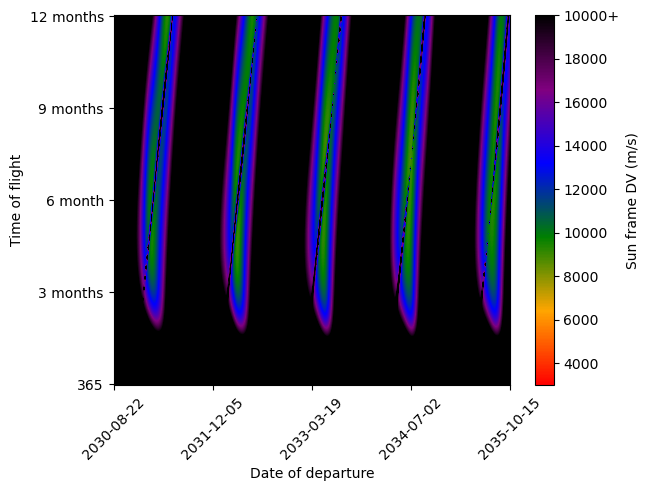

In [7]:
# Convert Astropy Time to Matplotlib dates

#print(mdates.date2num(dates))


start_date = mdates.date2num(dates[0][0][0].to_datetime())
end_date = mdates.date2num(dates[-1][0][0].to_datetime())

# Convert to a float and replace None with 0 (or another default value) cause non solutions go null in that array
clean_data = np.nan_to_num(dvs.astype(float)).transpose()

#t_time = dates[]

num_dates = 5
dates_l = np.linspace(start_date, end_date, num_dates)
date_labels = [mdates.num2date(date).strftime('%Y-%m-%d') for date in dates_l]
date_ticks = np.linspace(0, clean_data.shape[1] - 1, num_dates)
y_ticks = np.linspace(0, clean_data.shape[0] - 1, 5)  # 4 quarters + start of the year
y_labels = [clean_data.shape[0], '3 months', '6 month', '9 months', '12 months']
# Define a custom colormap from blue to red for the porkchop plot
#TBA proper coloring scheme!
#
cmap = colors.LinearSegmentedColormap.from_list("red_to_orange_to_green_to_blue_to_purple_to_black", ["red","orange","green", "blue","purple","black"])
#print(lowest_dv)
#print(y_labels)
# Create the plot
#print(dv_array[20,30])
plt.imshow(clean_data, cmap=cmap, aspect='auto', vmin=20000, vmax=lowest_dv,origin = 'lower')
# Set the x-ticks to correspond to the dates
plt.xticks(ticks=date_ticks, labels=date_labels, rotation=45)
plt.yticks(ticks=y_ticks, labels=y_labels)
#plt.ylim(bottom = lowest_dv)
#plt.title(f"Porkchop {Earth} to {arrivalBody}")
#plt.ylabel("DV from Earth surface Sun frame")
plt.ylabel("Time of flight")
plt.xlabel("Date of departure")
# ax2 = plt.twinx()
# ax2.set_ylabel("DV")

# Add colorbar and label it
cbar = plt.colorbar()
cbar.set_label("Sun frame DV (m/s)")  # Replace with the appropriate label for your data
ticks = cbar.get_ticks()
#ticks[-1] = ticks[-1] + 1  # Adjust top tick
cbar.set_ticks(ticks)
tick_labels = [f"{int(t)}" for t in ticks[:-1]] + ["10000+"]  # Replace top tick label
cbar.set_ticklabels(tick_labels)

# print(dv_array[60][13])
# print(date_array[60][13])


# Add a colorbar to show the mapping from data values to colors
#plt.colorbar()

# Show the plot
plt.show()


In [8]:
from astropy.time import Time, TimeDelta
import numpy as np

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates


epoch1 = Time("2031-08-17 12:05:50", scale="tdb")
epoch2 = Time("2033-10-17 12:05:50", scale="tdb")
epoch3 = Time("2034-11-17 12:05:50", scale="tdb")
MinTof = 0.1 << u.year
MaxTof = 1 << u.year
tejRes = 5 << u.day
tofRes = 5 << u.day

rows = int((epoch2-epoch1)/tejRes)
cols = int(365*u.day/tejRes)

maneuver_array = np.empty((rows, cols), dtype=object)
dv_array = np.empty((rows, cols), dtype=object)
date_array = np.empty((rows, cols), dtype=object)

##find the ephemeris of earth, mars at date of launch & at date of arrival
earth = Ephem.from_body(Earth, time_range(epoch1, end=epoch3))
mars = Ephem.from_body(Mars, time_range(epoch1, end=epoch3))

    ###Solve lambert for iterated TEJ, TOF
current_epoch = epoch1
for i in range(rows):
    current_epoch += tejRes
    #find the orbit of earth & mars at launch & landing
    # Solve for departure and target orbits
    ss_earth = Orbit.from_ephem(Sun, earth, current_epoch)
    currentTof = 15*u.day
    arrivalTime = current_epoch + currentTof
    ss_mars = Orbit.from_ephem(Sun, mars, arrivalTime)
    # Solve for the transfer maneuver 
    man_lambert = Maneuver.lambert(ss_earth, ss_mars)
    dv = np.linalg.norm(man_lambert[0][1].value)
    #print(dv)



In [9]:
from astropy import units as u

from poliastro.bodies import Earth, Mars
from poliastro.plotting.porkchop import PorkchopPlotter
from poliastro.util import time_range

launch_span = time_range("2005-04-30", end="2005-10-07")
arrival_span = time_range("2005-11-16", end="2006-12-21")
porkchop_plot = PorkchopPlotter(Earth, Mars, launch_span, arrival_span)
dv_dpt, dv_arr, c3dpt, c3arr, tof = porkchop_plot.porkchop()

ImportError: cannot import name 'PorkchopPlotter' from 'poliastro.plotting.porkchop' (c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\plotting\porkchop.py)

<class 'numpy.ndarray'>


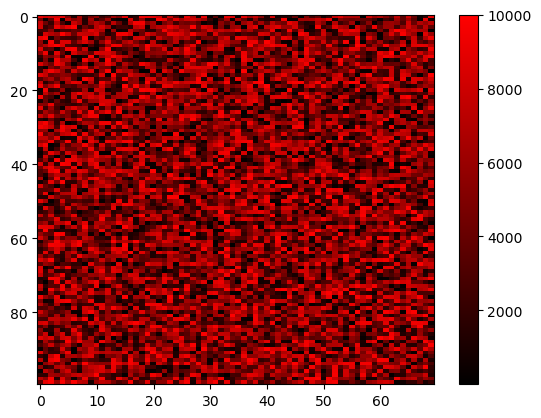

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Create a sample 2D array (100x70)
data = np.random.randint(0, 10001, (100, 70))
print(type(data))
# Define a custom colormap from black to red
cmap = colors.LinearSegmentedColormap.from_list("black_to_red", ["black", "red"])

# Create the plot
plt.imshow(data, cmap=cmap, aspect='auto')

# Add a colorbar to show the mapping from data values to colors
plt.colorbar()

# Show the plot
plt.show()

In [13]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"
from poliastro.twobody.events import LithobrakeEvent

R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value

alt = 150

orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m**2) / (100 * u.kg)).to_value(
    u.km**2 / u.kg
)  # km^2/kg
B = C_D * A_over_m

# parameters of the atmosphere
rho0 = rho0_earth.to(u.kg / u.km**3).value  # kg/km^3
H0 = H0_earth.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 100000 * u.s, num=2000))


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = atmospheric_drag_exponential(
        t0,
        state,
        k,
        R=R,
        C_D=C_D,
        A_over_m=A_over_m,
        H0=H0,
        rho0=rho0,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


rr, _ = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f)),
).rv()

plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, norm(rr, axis=1) - Earth.R)


orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)
tofs = TimeDelta(np.linspace(0 * u.h, 100 * u.d, num=2000))

lithobrake_event = LithobrakeEvent(R)
events = [lithobrake_event]

rr, _ = orbit.to_ephem(
    EpochsArray(
        orbit.epoch + tofs, method=CowellPropagator(f=f, events=events)
    ),
).rv()

print(
    "orbital decay seen after", lithobrake_event.last_t.to(u.d).value, "days"
)
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs[: len(rr)].value, norm(rr, axis=1) - Earth.R)

ImportError: cannot import name 'EpochsArray' from 'poliastro.twobody.sampling' (c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\twobody\sampling.py)

In [ ]:
from astropy import units as u

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver

# Data for Mars at J2000 from JPL HORIZONS
a = 1.523679 << u.AU
ecc = 0.093315 << u.one
inc = 1.85 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

orb = Orbit.from_classical(Sun, a, ecc, inc, raan, argp, nu)
orb.plot()

In [ ]:
orb_i = Orbit.circular(Earth, alt=700 << u.km)
# orb_i
# 7078 x 7078 km x 0.0 deg (GCRS) orbit around Earth (♁)
orb_i.plot()
hoh = Maneuver.hohmann(orb_i, 36000 << u.km)
hoh.get_total_cost()
# <Quantity 3.6173981270031357 km / s>
hoh.get_total_time()
# <Quantity 15729.741535747102 s>
orb_f=orb_i.apply_maneuver(hoh)
orb_f.plot()

In [ ]:
from poliastro.plotting import OrbitPlotter

op = OrbitPlotter(backend_name="matplotlib2D")
orb_a, orb_f = orb_i.apply_maneuver(hoh, intermediate=True)
op.plot(orb_i, label="Initial orbit")
op.plot(orb_a, label="Transfer orbit")
op.plot(orb_f, label="Final orbit")
op.show()

In [2]:
import numpy as np

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting import OrbitPlotter3D
